## Basic word2vec implementation

In [58]:
import collections
import math
import os
import random
import zipfile
import numpy as np
from six.moves import urllib
import tensorflow as tf
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### Step 1: Download data

In [2]:
url = 'http://mattmahoney.net/dc/'

Download the file if not already present

In [3]:
def maybe_download(filename, expected_bytes):
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url+filename, filename)
    
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified ', filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ', filename)
    return filename

In [4]:
filename = maybe_download('text8.zip', 31344016)

Found and verified  text8.zip


Read the data into a list of strings
* extract the first file enclosed in the zip as a list of words

In [5]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

In [6]:
vocab = read_data(filename)

In [7]:
print('Vocab size: ', len(vocab))

Vocab size:  17005207


### Step 2: Build dictionary and replace rare words with UNK token

In [8]:
vocab_size = 50000

In [31]:
count = [['UNK', -1]]
count.extend(collections.Counter(vocab).most_common(vocab_size - 1))

In [32]:
count[:10]

[['UNK', -1],
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430)]

In [33]:
word2idx = dict()
for word, _ in count:
    word2idx[word] = len(word2idx)

In [34]:
data = list()
idx2word = dict(zip(word2idx.values(), word2idx.keys()))
unk_count = 0
for word in vocab:
    if word in word2idx:
        index = word2idx[word]
    else:
        index = 0 # dictionary['UNK']
        unk_count += 1
    
    data.append(index)
    count[0][1] = unk_count

In [36]:
print('Most common words (+UNK)', count[:5])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]


In [37]:
print('Sample data, data', data[:10], [idx2word[i] for i in data[:10]])

Sample data, data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


### Step 3: Generate batch for the skip-gram model

In [45]:
data_index = 0
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2*skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [skip_window *target* skip_window]
    buffer = collections.deque(maxlen=span)
    
    if data_index + span > len(data):
        data_index = 0
    
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    
    for i in range(batch_size // num_skips):
        target = skip_window # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            
            targets_to_avoid.append(target)
            batch[i * num_skips  + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        
        if data_index == len(data):
            buffer[:] = data[:span]
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    
    # Backtrack a bit to avoid skipping words at the end of the batch
    data_index = (data_index + len(data) - span) % len(data)
    
    return batch, labels

### Step 4: Build Skip-gram Model

In [49]:
batch_size = 128
embedding_size = 128 # dim of embedding vector
skip_window = 1 # How many words to consider left and right from target
num_skips = 2 # How many times to reuse an input to generate labels

We pick a random validation set to sample nearest neigbors. Here we limit the validation samples to the words that have a low numeric ID, which in our case is also the most frequent words

In [51]:
valid_size = 16 # Random set of words to evaluate similarity on
valid_window = 100 # Only pick dev samples in the head of distribution
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64 # Number of negative examples to sample

In [52]:
graph = tf.Graph()

In [54]:
with graph.as_default():
    # Input data
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    embeddings = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    # Construct variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocab_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocab_size]))
    
    # compute the average NCE loss for the batch
    # tf.nce_loss automatically draws a new sample of the negative labels
    # each time we evaluate the loss
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                         biases=nce_biases,
                                         labels=train_labels,
                                         inputs=embed,
                                         num_sampled=num_sampled,
                                         num_classes=vocab_size))
    
    # Construct the SGD optimizer
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    
    # Compute the cosine similarity between minibatch examples and all embeddings
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
    
    # Add variable initializer
    init = tf.global_variables_initializer()

### Step 5: Train Model

In [55]:
num_steps = 100001

In [57]:
with tf.Session(graph=graph) as session:
    init.run()
    
    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
                # The average loss is an estimate of the loss over the last 2000 batches
                print('Average loss at step ', step, ': ', average_loss)
                average_loss = 0
        
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = idx2word[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to {}'.format(valid_word)
                
                for k in range(top_k):
                    close_word = idx2word[nearest[k]]
                    log_str = '{}{},'.format(log_str, close_word)
                print(log_str)
                
    final_embeddings = normalized_embeddings.eval()

Nearest to theystraight,ole,depressions,ber,dudley,degree,obscura,retreated,
Nearest to someeia,wales,highlight,aladdin,ministers,drumming,foe,moab,
Nearest to historyherzl,regan,pushes,yeti,preservation,avraham,seasonal,polite,
Nearest to allincrement,haag,barge,commodores,busoni,tay,xl,piety,
Nearest to firstpredominance,cheng,deflate,predicates,sore,canoe,singapore,his,
Nearest to newtrip,premise,epirus,danville,anakin,cast,elegance,occurrence,
Nearest to notcertain,doctors,copland,second,advisors,speedy,ungodly,hadrian,
Nearest to fourcassini,wilderness,hecate,subroutine,vci,erecting,appealing,elle,
Nearest to heexterminate,parva,dazzle,wwe,esoteric,oceanographer,nonsignatory,marble,
Nearest to suchbitmap,gaines,pagans,revitalization,derivates,ribbentrop,foulke,hopelessly,
Nearest to ofobrenovi,octave,pornography,prosaic,drew,brazilian,dining,necrosis,
Nearest to hasshrine,paws,repugnant,coca,rainer,em,dose,math,
Nearest to whenreissued,axels,plantations,ibero,blood,bradbury,antige

Average loss at step  62000 :  5.02474156892
Average loss at step  64000 :  4.8468452251
Average loss at step  66000 :  4.59112988734
Average loss at step  68000 :  5.01058454597
Average loss at step  70000 :  4.88791900146
Nearest to theywe,there,he,it,you,she,who,classified,
Nearest to somemany,these,any,all,other,their,ursus,several,
Nearest to historythaler,agouti,shaw,hydroxyl,ligatures,flashing,list,main,
Nearest to allsome,thibetanus,these,thaler,three,bohdan,people,circ,
Nearest to firstlast,agouti,marek,second,original,thaler,checkers,abet,
Nearest to newspecial,arctos,cast,agouti,gigantopithecus,callithrix,premise,panipat,
Nearest to notgenerally,they,keto,to,also,it,now,there,
Nearest to foursix,five,three,eight,seven,two,nine,zero,
Nearest to heit,she,they,who,there,ursus,we,later,
Nearest to suchthese,well,some,considerable,many,pagans,eleventh,halpin,
Nearest to ofmitral,and,ursus,abet,in,tabula,for,thaler,
Nearest to hashad,have,was,is,became,ursus,vdc,sorcerer,
Nearest 

### Step 6: Visualize the embeddings

In [59]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [idx2word[i] for i in range(plot_only)]

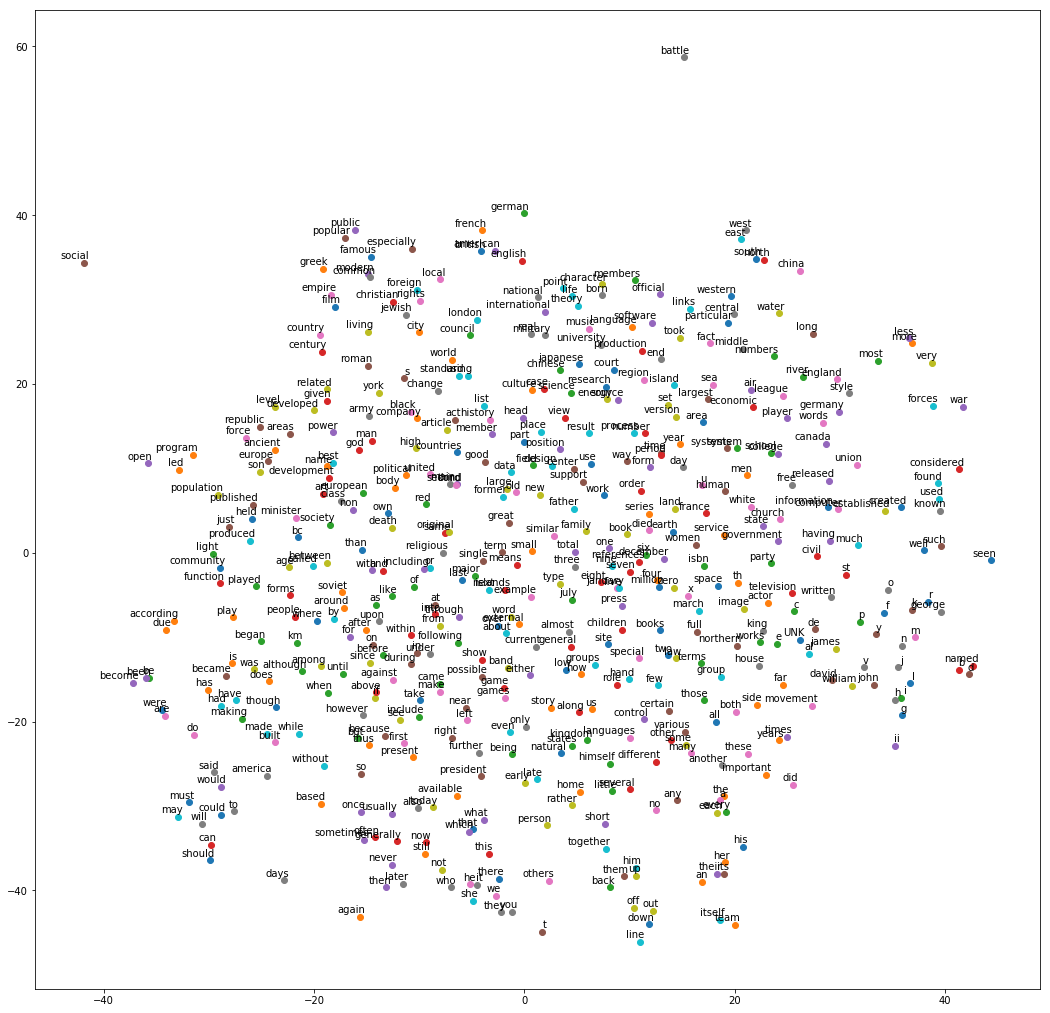

In [60]:
plt.figure(figsize=(18, 18))
for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

plt.show()